In [1]:
import torch
import matplotlib.pyplot as plt
from skripsi_program import (
    Burgers,
    FourierBasis,
    # to_complex_coeff,
    to_real_coeff,
    StandardScaler,
    SpectralSVR,
    Basis,
    # resize_modes,
)

In [2]:
plt.rcParams.update(
    {
        # "text.usetex": True,  # use TeX for all texts
        "font.family": "serif",
        "font.size": 12,  # control font sizes of different elements
        # "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    }
)

In [3]:
generator = torch.Generator().manual_seed(42)
time_domain = slice(0, 10, 2000)
space_domain = slice(0, 2, 2000)
periods = (time_domain.stop - time_domain.start, space_domain.stop - space_domain.start)
nu = 0.1
problem = Burgers()

u_rand, f_rand = problem.generate(
    basis=FourierBasis,
    n=40,
    modes=(25),
    nu=nu,
    u0="random",
    f="random",
    generator=generator,
    time_domain=time_domain,
    space_domain=space_domain,
    time_dependent_coeff=False,
)
u_rand.coeff.isnan().sum()

tensor(0)

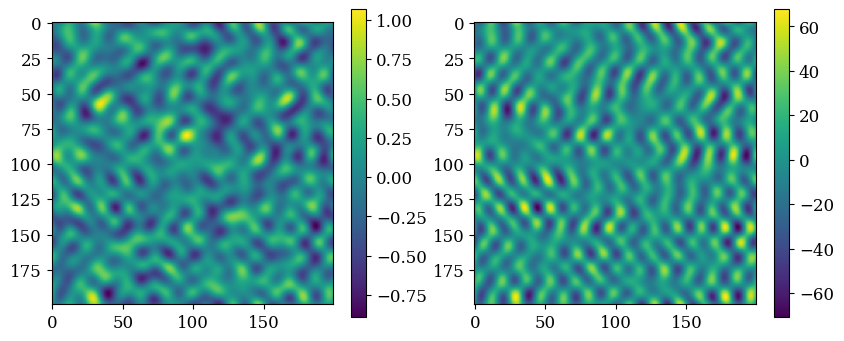

In [4]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
u_rand.plot(i=0, aspect="equal")
# plt.legend(["initial condition", "mid condition", "final condition"])
plt.colorbar()
plt.subplot(122)
f_rand.plot(i=0, aspect="equal")
plt.colorbar()

In [5]:
u_an = u_rand.to_time_independent()
f_an = f_rand.to_time_independent()
# u_an = u_rand.to_time_dependent()
# f_an = f_rand.to_time_dependent()

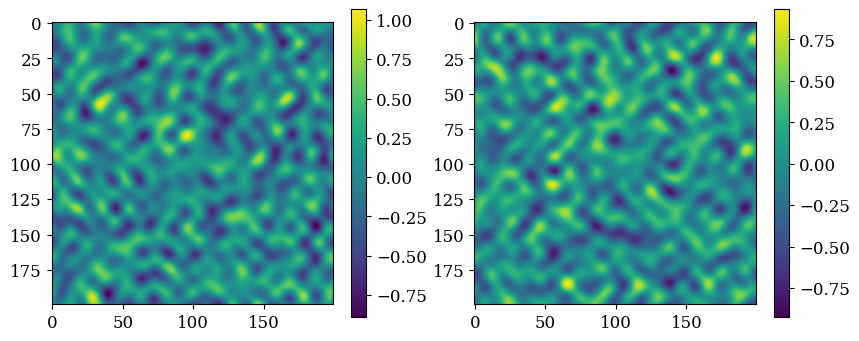

In [6]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
u_an.plot(i=0, aspect="equal")
# plt.legend(["initial condition", "mid condition", "final condition"])
plt.colorbar()
plt.subplot(122)
u_an.plot(i=1, aspect="equal")
plt.colorbar()

tensor(0.)

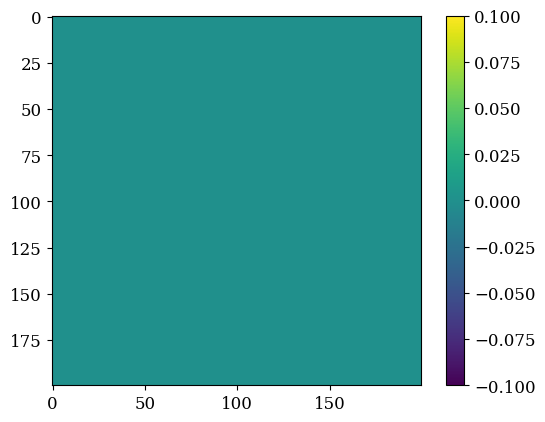

In [7]:
tmp = problem.spectral_residual(u_rand, f_rand, nu)
tmp.plot()
plt.colorbar()
tmp.coeff.abs().max()

In [8]:
import torch.utils
import torch.utils.data


u_10 = u_rand.perturb()
f_10 = f_rand.perturb()
n = len(u_10)
n_train = int(0.6 * n)


def get_input_output(u: Basis, f: Basis, time_res: slice):
    # get values at time resolution
    spatial_modes = u.to_time_dependent().modes[0]
    spatial_res = slice(0, u.periods[1], spatial_modes)
    res = (time_res, spatial_res)

    u_val = u.get_values(res=res)
    f_val = f.get_values(res=res)
    # get the coefficients at the time resolution
    u_coeff = u.transform(u_val.flatten(0, 1)).unflatten(0, u_val.shape[:2])
    f_coeff = u.transform(f_val.flatten(0, 1)).unflatten(0, f_val.shape[:2])
    # merge sample and time dimension
    # future time step
    un = u_coeff[:, 1:].flatten(0, 1)
    # current time step
    uc = u_coeff[:, :-1].flatten(0, 1)
    fc = f_coeff[:, 1:].flatten(0, 1)
    # merge all spatial coefficient dimensions and convert to real valued coefficients
    uc_flat = to_real_coeff(uc.flatten(1))
    fc_flat = to_real_coeff(fc.flatten(1))
    x = torch.concat((uc_flat, fc_flat), dim=1)
    y = to_real_coeff(un.flatten(1))
    return x, y


time_res = slice(time_domain.start, time_domain.stop, 40)
x_train, y_train = get_input_output(u_10[:n_train], f_10[:n_train], time_res=time_res)
x_test, y_test = get_input_output(u_10[n_train:], f_10[n_train:], time_res=time_res)
n_train, n - n_train, x_train.shape, y_train.shape, x_test.shape, y_test.shape

(24,
 16,
 torch.Size([936, 100]),
 torch.Size([936, 50]),
 torch.Size([624, 100]),
 torch.Size([624, 50]))

In [9]:
from torchmetrics.functional import r2_score, mean_squared_error


truth = to_real_coeff(x_train[:, :y_train.shape[1]]).contiguous()
pred = to_real_coeff(y_train[:]).contiguous()
r2_score(pred, truth), mean_squared_error(pred, truth)


(tensor(-0.0329), tensor(1.0732))

In [10]:
from torch.utils.data import TensorDataset, random_split

df_train = TensorDataset(x_train, y_train)
df_train, df_val = random_split(df_train, (5 / 6, 1 / 6), generator=generator)
df_test = TensorDataset(x_test, y_test)
x_train, y_train = df_train[: min(4000, len(df_train))]
x_val, y_val = df_val[: min(4000, len(df_val))]
x_test, y_test = df_test[: min(4000, len(df_test))]
scaler = StandardScaler().fit(x_train)
input_train = scaler.transform(x_train)
input_val = scaler.transform(x_val)
input_test = scaler.transform(x_test)
output_train = y_train
output_val = y_val
output_test = y_test

In [11]:
output_train.shape

torch.Size([780, 50])

In [12]:
space_period = space_domain.stop - space_domain.start
model = SpectralSVR(
    FourierBasis(periods=space_period),
    C=1.0,
)
model.train(input_train, output_train)
model.test(input_val, output_val), model.test(input_test, output_test)


({'spectral': {'mse': 0.21596674621105194,
   'rmse': 0.464722216129303,
   'mae': 0.3177749514579773,
   'r2': 0.8079742193222046,
   'smape': 0.6521401405334473,
   'rse': 0.19252018630504608,
   'rrse': 0.38849422335624695,
   'pred_nan_sum': 0},
  'function value': {'mse': 0.01726478897035122,
   'rmse': 0.13139554858207703,
   'mae': 0.10559476912021637,
   'r2': 0.7933914661407471,
   'smape': 0.7652376294136047,
   'rse': 0.20660847425460815,
   'rrse': 0.45394816994667053,
   'pred_nan_sum': 0}},
 {'spectral': {'mse': 0.24556085467338562,
   'rmse': 0.495540976524353,
   'mae': 0.3364163339138031,
   'r2': 0.7858038544654846,
   'smape': 0.6898784637451172,
   'rse': 0.21688781678676605,
   'rrse': 0.41153162717819214,
   'pred_nan_sum': 0},
  'function value': {'mse': 0.019657080993056297,
   'rmse': 0.14020371437072754,
   'mae': 0.11207016557455063,
   'r2': 0.7637731432914734,
   'smape': 0.8028716444969177,
   'rse': 0.23622682690620422,
   'rrse': 0.48581448197364807,
   

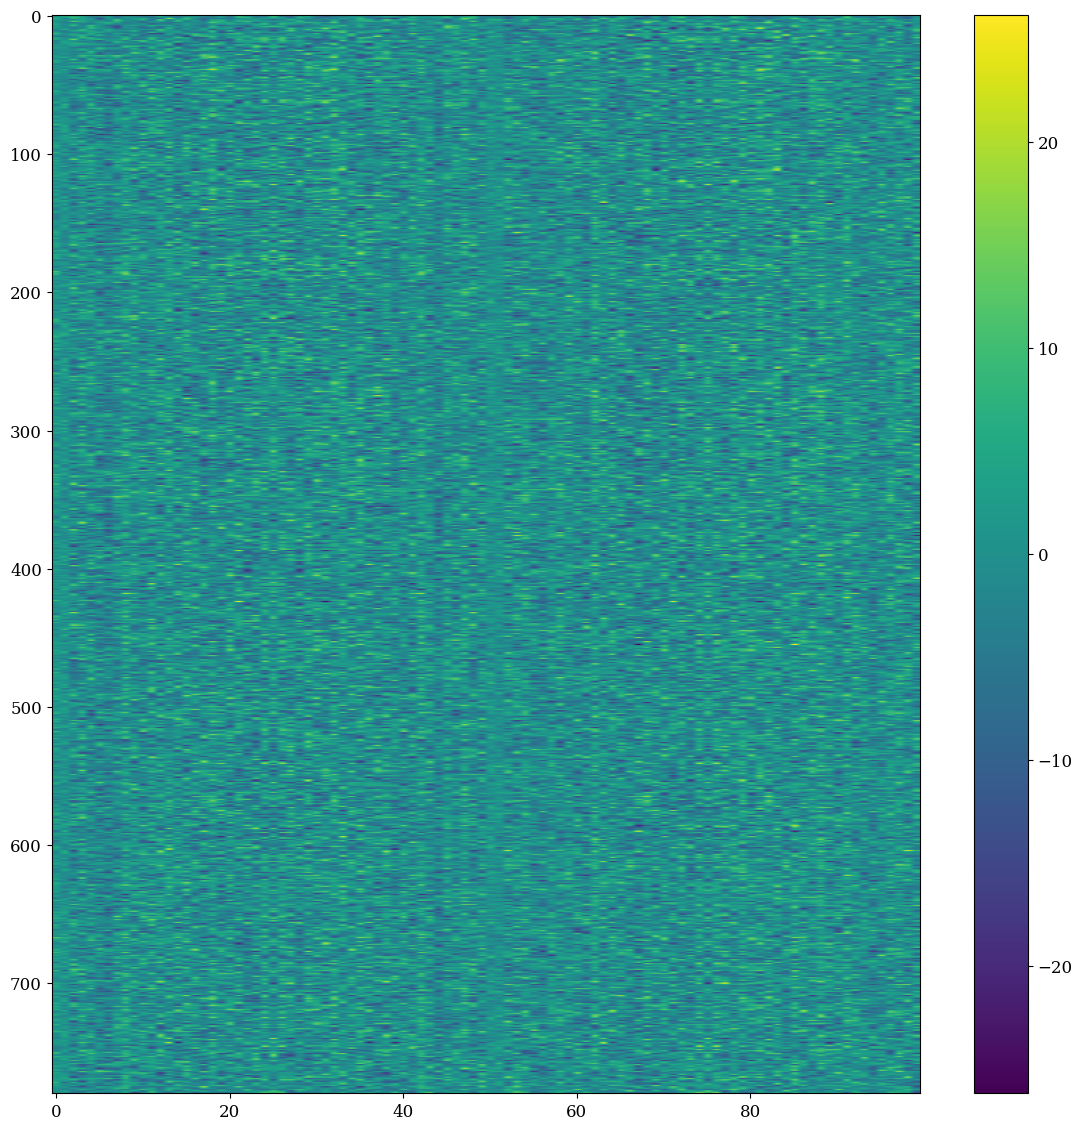

In [13]:
corr_image = model.svr.get_correlation_image()
plt.figure(figsize=(14, 14))
plt.imshow(corr_image, aspect="auto")
plt.colorbar()


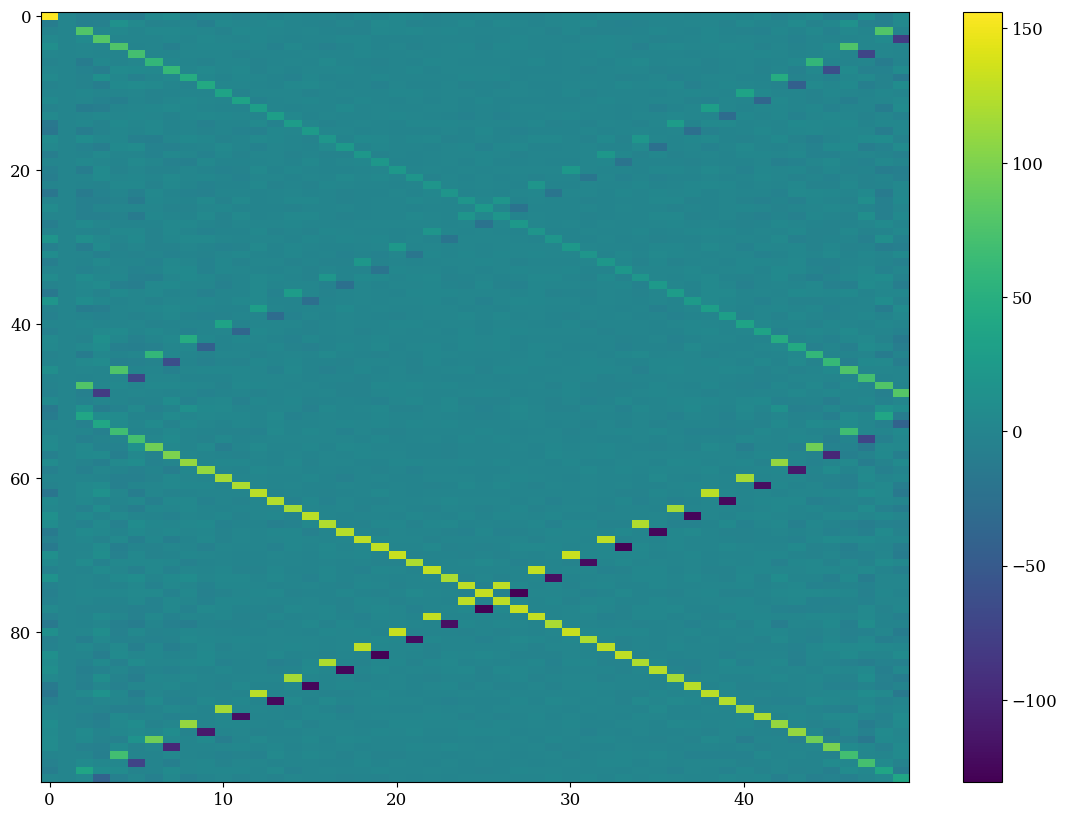

In [14]:
p_matrix = model.svr.get_p_matrix()
plt.figure(figsize=(14, 10))
plt.imshow(p_matrix, aspect="auto")
plt.colorbar()

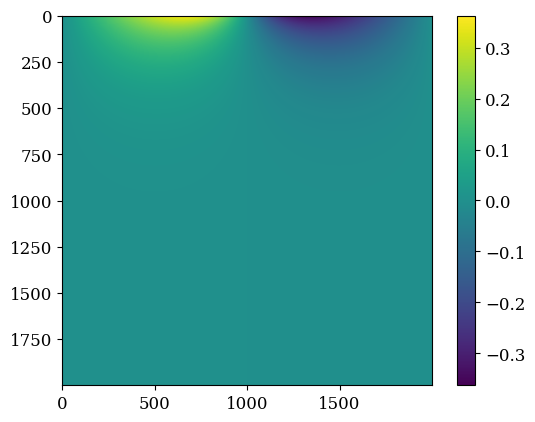

In [15]:
grid = FourierBasis.grid(res=(time_domain, space_domain))
c = 2.0


def u_exact(x: torch.Tensor, t: torch.Tensor, nu: float = 0.01, c: float = 2.0):
    # use p. 705-706 Partial Differential Equations and Solitary Waves Theory, Abdul-Majid Wazwaz
    # eq 1.5 doi: 10.1090/QAM/306736
    # doi: 10.1002/cnm.850
    pi = torch.pi
    # neg_pi2_nu_t = -(pi**2) * nu * t
    # exp_neg_pi2_nu_t = neg_pi2_nu_t.exp()
    pi_x = pi * x
    # u = 2*x.sin()/(x.cos()-t.exp())
    # u = (2 * (nu**2) * pi * exp_neg_pi2_nu_t * pi_x.sin()) / (c + pi_x.cos())
    u = (2 * nu * pi * pi_x.sin()) / (c * t.mul(pi**2 * nu).exp() + pi_x.cos())
    return u


u_val = u_exact(grid[..., 1], grid[..., 0], nu=nu, c=c)
plt.imshow(u_val)
plt.colorbar()

In [16]:
dt = grid[1, 0, 0] - grid[0, 0, 0]
dx = grid[0, 1, 1] - grid[0, 0, 1]
dt, dx


(tensor(0.0050), tensor(0.0010))

tensor(0.0112)

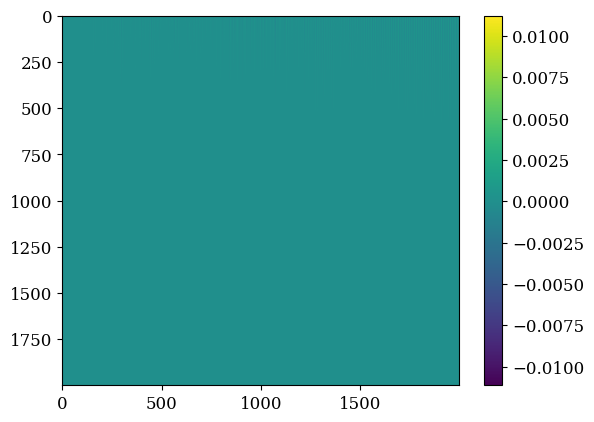

In [17]:
f_e = FourierBasis(
    FourierBasis.generate_empty(3000, 20).unsqueeze(0),
    time_dependent=True,
    periods=periods,
)
f_val = f_e.get_values(res=(time_domain, space_domain))[0].real.cpu()


def residual_func(u_val, f_val):
    u_t = torch.gradient(u_val, spacing=dt.item(), dim=0, edge_order=2)[0]

    u_x = torch.gradient(u_val, spacing=dx.item(), dim=1, edge_order=2)[0]
    u_xx = torch.gradient(u_x, spacing=dx.item(), dim=1, edge_order=2)[0]

    uu_x = u_val * u_x
    residual = u_t + uu_x - nu * u_xx - f_val

    return residual


residual = residual_func(u_val, f_val)
plt.imshow(residual, aspect="auto")
plt.colorbar()
residual.abs().max()

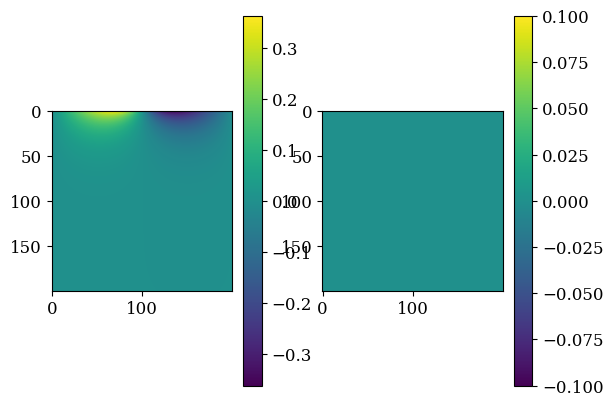

In [18]:
exact_coeff = FourierBasis.transform(u_val)
u_e = FourierBasis(exact_coeff.unsqueeze(0), time_dependent=True, periods=periods)
f_e = FourierBasis(
    FourierBasis.generate_empty(1, exact_coeff.shape),
    time_dependent=True,
    periods=periods,
)
plt.subplot(121)
u_e.plot()
plt.colorbar()
plt.subplot(122)
f_e.plot()
plt.colorbar()

torch.Size([2000, 2000]) torch.Size([2000, 2000])


tensor(4.2495)

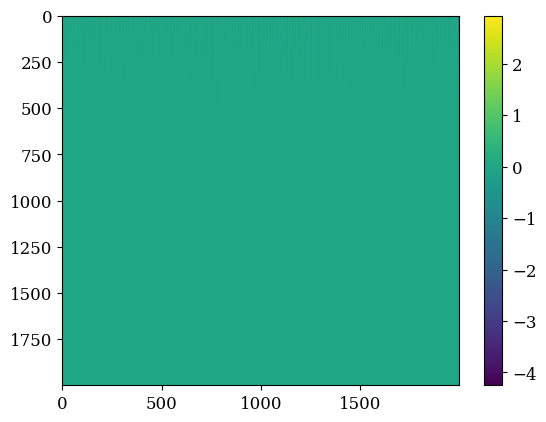

In [19]:
u_val = u_e.get_values()[0].real
f_val = f_e.get_values()[0].real
print(u_val.shape, f_val.shape)
residual = residual_func(u_val, f_val)
plt.imshow(residual, aspect="auto")
plt.colorbar()
residual.abs().max()

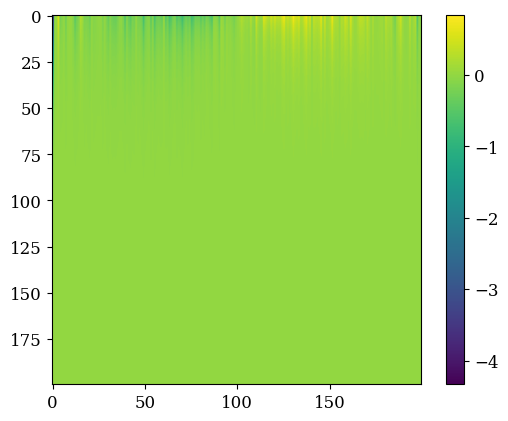

In [20]:
# problem.spectral_residual(u_rand, f_rand, nu).plot()
problem.spectral_residual(u_e, f_e, nu).plot()
plt.colorbar()

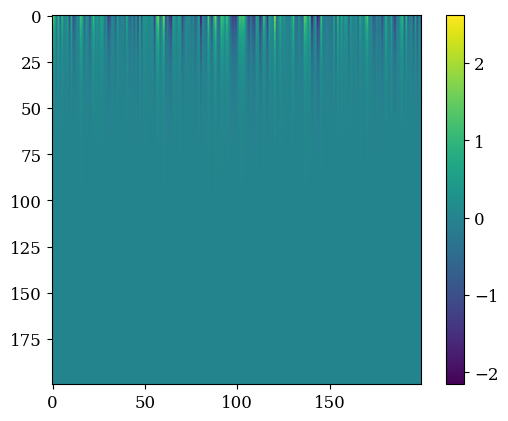

In [21]:
# problem.residual(u_rand, f_rand, nu).plot()
problem.residual(u_e, f_e, nu).plot()
plt.colorbar()